# Event Study für Cevian und UBS

## Import Packages

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
import statsmodels.api as sm
import numpy as np
from scipy.stats import t, norm
from IPython.core.debugger import Pdb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import requests
import zipfile
import io
import pdb



# Read In Data
I first read in the Fama French factor data and the data for the UBS stock obtained from yahoo finance

In [2]:
def get_fama_french_daily_factors():
    """This function downloads the Fama French daily factors from the Kenneth French data library and returns a pandas DataFrame."""

    url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip'
    
    response = requests.get(url)
    
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        with z.open('F-F_Research_Data_Factors_daily.CSV') as f:
            df = pd.read_csv(f, skiprows=4, skipfooter=2, engine='python')# Remember to skip the header and footer

    return df

In [3]:
def clean_fama_french_factor_data(raw_data):
    """This function cleans the Fama French factor data set obtained from the Kenneth French data library."""

    cleaned_data = pd.DataFrame()
    cleaned_data['Date'] = raw_data['Unnamed: 0'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
    cleaned_data['Date'] = cleaned_data['Date'].dt.tz_localize(None)
    cleaned_data['Mkt-RF'] = raw_data['Mkt-RF'].astype(float)
    cleaned_data['RF'] = raw_data['RF'].astype(float)
    cleaned_data['SMB'] = raw_data['SMB'].astype(float)
    cleaned_data['HML'] = raw_data['HML'].astype(float)
    cleaned_data["Mkt"] = cleaned_data["Mkt-RF"] + cleaned_data["RF"]

    return cleaned_data

In [4]:
raw_fama_french_data = get_fama_french_daily_factors()
fama_french_data = clean_fama_french_factor_data(raw_fama_french_data)


In [5]:
def clean_stock_returns(df):
    """
    Cleans stock returns data from yahoo finance.

    This function takes a DataFrame returned by yfinance.download and performs the following operations:
    1. Restructures the multi-index columns to have a separate Ticker column
    2. Ensures the 'Date' column is a datetime object
    3. Calculates the daily return as the percentage change from the 'Adj Close' column

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the stock returns data with multi-index columns
                          ['Price', 'Ticker']

    Returns:
    df (pandas.DataFrame): The cleaned DataFrame with single-level columns plus Ticker column
    """
    # Store the ticker name
    ticker = df.columns.get_level_values('Ticker')[0]
    
    # Get the first level column names and remove the 'Price' level entirely
    df.columns = [col[0] for col in df.columns]
    
    # Add Ticker column
    df['Ticker'] = ticker
    
    # Ensure the 'Date' column is datetime
    df.index = pd.to_datetime(df.index)
    df['Date'] = df.index
    df['Date'] = df['Date'].dt.tz_localize(None)
    
    # Reset the index
    df = df.reset_index(drop=True)
    
    # Calculate the daily return
    df['Daily_Return'] = df['Adj Close'].pct_change()
    
    return df

In [6]:
# Define the ticker symbol
tickerSymbol = 'UBS'

# Get data from the start of 2023 to the current date
raw_stock_data = yf.download(tickerSymbol, start='2022-01-01')




[*********************100%***********************]  1 of 1 completed


In [7]:
raw_stock_data.columns

MultiIndex([('Adj Close', 'UBS'),
            (    'Close', 'UBS'),
            (     'High', 'UBS'),
            (      'Low', 'UBS'),
            (     'Open', 'UBS'),
            (   'Volume', 'UBS')],
           names=['Price', 'Ticker'])

In [8]:
stock_data = clean_stock_returns(raw_stock_data)

In [9]:
stock_data.head()

,Adj Close,Close,High,Low,Open,Volume,Ticker,Date,Daily_Return
0,16.737690,18.120001,18.165001,17.969999,17.980000,1887200,UBS,2022-01-03,NaN
1,17.199545,18.620001,18.698999,18.440001,18.500000,2363300,UBS,2022-01-04,0.027594
2,16.987089,18.389999,18.740000,18.340000,18.660000,2868200,UBS,2022-01-05,-0.012352
3,17.569031,19.020000,19.049999,18.770000,18.920000,4109400,UBS,2022-01-06,0.034258
4,17.873857,19.350000,19.389999,19.230000,19.299999,3074600,UBS,2022-01-07,0.017350


## Functions to run the event study

In [171]:
def run_event_study_single_event(stock_data, event_date, factor_data, estimation_window = [-250, 0], event_window = [0, 20] ):
    """This function runs an event study for a single event.
    Args:
    stock_data (pandas.DataFrame): Stock data generated by the function clean_capital_iq_stock_data
    event_date (pd.Datetime): Date of the event
    estimation_window (list): Estimation window for the event study
    event_window (list): Event window for the event study
 
    Returns:
    pandas.DataFrame: Event study results
    """
  

    # Estimate the normal returns
    normal_returns, degrees_of_freedom, residual_variance, X_cov = estimate_normal_returns(stock_data, factor_data, event_date, estimation_window)

    # Generate the event study output
    event_study_output = generate_event_study_output(stock_data, event_date, normal_returns, residual_variance, degrees_of_freedom, X_cov, event_window)

    return event_study_output





def estimate_normal_returns(stock_data, factor_data, event_date, estimation_window = [-150, 0]):
    """This function estimates the normal return model for the event study.
    Args:
    stock_data (pandas.DataFrame): Stock data from the clean_capital_iq_stock_data function
    factor_data (pandas.DataFrame): Factor data from the clean_fama_french_factor_data function
    event_date (datetime): Event date
    estimation_window (list): Estimation window for the event study

    Returns:
    pandas.Dataframe: 
            columns:    Normal returns (float) Estimated normal returns for full data
                        Date (datetime) Date of the data
    int: degrees of freedom as an integer

    """

    # Define the start and end of the estimation window
    start_date = event_date + timedelta(days=estimation_window[0])
    end_date = event_date + timedelta(days=estimation_window[1])

    #Ensure that the event date is timezone-naive
    if event_date.tzinfo is not None:
        event_date = event_date.tz_localize(None)
    


    # Filter the stock and factor data for the estimation window
    stock_data_window = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]

    factor_data_window = factor_data[(factor_data['Date'] >= start_date) & (factor_data['Date'] <= end_date)]


    # Merge the stock and factor data
    merged_data = pd.merge(stock_data_window, factor_data_window, on='Date', validate="1:1").dropna()

    # Run the OLS regression
    X = sm.add_constant(merged_data['Mkt'])  # Add a constant to the independent variable
    model = sm.OLS(merged_data['Daily_Return'], X)
    results = model.fit()

    # Use the fitted model to estimate the normal returns for the full data
    full_data = pd.merge(stock_data, factor_data, on='Date')
    full_data['Normal_Returns'] = results.predict(sm.add_constant(full_data['Mkt']))

    degrees_of_freedom = estimation_window[1] - estimation_window[0] - 1
    X_cov = np.linalg.inv(np.dot(X.T, X))  # (X'X)^(-1)

    residual_variance = results.ssr / results.df_resid


    return full_data[['Date', 'Normal_Returns', 'Mkt']], degrees_of_freedom, residual_variance, X_cov


def generate_event_study_output(stock_data, event_date, normal_returns,residual_variance, degrees_of_freedom, X_cov, event_window=[0, 20] ):
    """This function generates the output for the event study.
    Args:
    stock_data (pandas.DataFrame): Stock data from the clean_capital_iq_stock_data function
    event_data (pandas.DataFrame): Event data
    normal_returns (pandas.DataFrame): Normal returns from the estimate_normal_returns function
    event_window (list): Event window for the event study

    Returns:
    pandas.DataFrame: Event study results

    """


    # Define the start and end of the event window
    start_date = event_date + timedelta(days=event_window[0] )
    end_date = event_date + timedelta(days=event_window[1]) 

    # Merge the stock data and normal returns
    merged_data = pd.merge(stock_data, normal_returns, on='Date')

    # Filter the merged data for the event window
    event_window_data = merged_data[(merged_data['Date'] >= start_date) & (merged_data['Date'] <= end_date)]

    # Calculate the abnormal returns
    event_window_data['Abnormal_Returns'] = event_window_data['Daily_Return'] - event_window_data['Normal_Returns']

    #Calculate the cumulative abnormal returns
    event_window_data.loc[:,'Cumulative_Abnormal_Returns'] = event_window_data['Abnormal_Returns'].cumsum()

    # Calculate CAR_Variance
    event_window_data['CAR_Variance'] = 0.0  # Initialize the column
    
    for i in range(len(event_window_data)):
        # Get X_star up to current row (cumulative)
          # Get market returns up to current row
        mkt_returns = event_window_data['Mkt'].iloc[:i+1]
        # Create X_star with ones column and market returns
        X_star = np.column_stack([np.ones(len(mkt_returns)), mkt_returns])

        # Calculate CAR variance using the formula
        # CAR_Variance = σ²ε * (1 + X*'(X'X)⁻¹X*) times T
        variance = residual_variance * (np.ones(len(mkt_returns)) + (X_star @ X_cov @ X_star.T))
        
        event_window_data.iloc[i, event_window_data.columns.get_loc('CAR_Variance')] = np.ones(len(mkt_returns)) @ variance @ np.ones(len(mkt_returns)).T
  

    #Calculate CI's
    event_window_data.loc[:,"CI_upper_bound_95"] = event_window_data["Cumulative_Abnormal_Returns"] + t.ppf(0.975, degrees_of_freedom) * np.sqrt(event_window_data["CAR_Variance"])

    event_window_data.loc[:,"CI_lower_bound_95"] = event_window_data["Cumulative_Abnormal_Returns"] - t.ppf(0.975, degrees_of_freedom) * np.sqrt(event_window_data["CAR_Variance"])

    #Calculate t-statistic
    event_window_data.loc[:,"t-statistic"] = event_window_data["Cumulative_Abnormal_Returns"] / np.sqrt(event_window_data["CAR_Variance"])

    #Calculate p-value
    event_window_data.loc[:,"p-value"] = 1 - t.cdf(abs(event_window_data["t-statistic"]), degrees_of_freedom)


    return event_window_data


## Run the Event Study

In [172]:
event_study_results = run_event_study_single_event(
    stock_data=stock_data,
    event_date=pd.to_datetime('2023-12-19'),
    factor_data=fama_french_data,
    estimation_window=[-365, -1],
    event_window=[0, 20]
)

/var/folders/f_/lhmm20kd6r979skh60tngks80000gn/T/ipykernel_69290/1040465591.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_window_data['Abnormal_Returns'] = event_window_data['Daily_Return'] - event_window_data['Normal_Returns']
/var/folders/f_/lhmm20kd6r979skh60tngks80000gn/T/ipykernel_69290/1040465591.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_window_data.loc[:,'Cumulative_Abnormal_Returns'] = event_window_data['Abnormal_Returns'].cumsum()
/var/folders/f_/lhmm20kd6r979skh60tn

In [173]:
event_study_results.head()

,Adj Close,Close,High,Low,Open,Volume,Ticker,Date,Daily_Return,Normal_Returns,Mkt,Abnormal_Returns,Cumulative_Abnormal_Returns,CAR_Variance,CI_upper_bound_95,CI_lower_bound_95,t-statistic,p-value
493,29.925150,30.709999,30.930000,30.000000,30.139999,12476100,UBS,2023-12-19,0.051712,0.010126,0.741,0.041586,0.041586,0.000258,0.073189,0.009984,2.587772,0.005024
494,29.554863,30.330000,30.850000,30.280001,30.500000,7621100,UBS,2023-12-20,-0.012374,-0.017507,-1.539,0.005133,0.046720,0.001032,0.109895,-0.016456,1.454271,0.073368
495,29.886173,30.670000,30.825001,30.455000,30.740000,4531200,UBS,2023-12-21,0.011210,0.014610,1.111,-0.003400,0.043319,0.002319,0.138024,-0.051385,0.899515,0.184487
496,30.100550,30.889999,31.129999,30.725000,30.760000,4259000,UBS,2023-12-22,0.007173,0.003824,0.221,0.003349,0.046669,0.004123,0.172942,-0.079605,0.726795,0.233910
497,30.246717,31.040001,31.150000,30.790001,30.790001,4223600,UBS,2023-12-26,0.004856,0.007217,0.501,-0.002361,0.044307,0.006443,0.202153,-0.113539,0.552000,0.290644


## Plot Event Study Results

In [174]:
def plot_CAR_over_time_with_ci_seaborn(event_study_results, stock_market_data, event_date, confidence_level=0.95, plot_colors = ["#3c5488", "#e64b35", "#4dbbd5", "#00a087", "#f39b7f", "#000000"]):
    """
    Plot Cumulative Abnormal Returns (CAR) over time with confidence intervals using Seaborn.

    Args:
    event_study_results (pandas.DataFrame): DataFrame generated by the function generate_event_study_output
    event_data (pandas.DataFrame): DataFrame containing event data as generated by the clean_data_breach_dataset function
    confidence_level (float, optional): Confidence level for confidence intervals, default is 0.95.
    event_date (datetime, optional): Date of the event, default is None.

    Returns:
    None (displays the Seaborn figure)
    """

    #Raw Data
    start_date = event_date + np.timedelta64(-50, 'D')
    end_date=event_study_results['Date'].max()

    plot_title = f"Event Study Output"

    filtered_stock_data = stock_market_data[(stock_market_data['Date'] >= start_date) &
                                        (stock_market_data['Date'] <= end_date)]
    
    # Set the white theme and LaTeX font
    sns.set_theme(style="white", rc={"text.usetex": True})

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the data
    sns.lineplot(x='Date', y='Daily_Return', data=filtered_stock_data, ax=ax, label='Observed Return', color=plot_colors[5], linestyle=':')
    sns.lineplot(x='Date', y='Normal_Returns', data=event_study_results, ax=ax, label='Normal Return', color=plot_colors[0], linestyle='--')
    sns.lineplot(x='Date', y='Abnormal_Returns', data=event_study_results, ax=ax, label='Abnormal Return', color=plot_colors[3])
    sns.lineplot(x='Date', y='Cumulative_Abnormal_Returns', data=event_study_results, ax=ax, label='Cumulative Abnormal Return', color=plot_colors[2])

    # Add confidence intervals
    ax.fill_between(event_study_results['Date'], event_study_results['CI_lower_bound_95'], event_study_results['CI_upper_bound_95'], color='grey', alpha=0.1)

    # Add the event date line
    ax.axvline(x=event_date, color='grey', linestyle='--')

    # Add a grey dotted line at x=0
    ax.axhline(0, color='grey', linestyle='-', alpha=0.5)

    # Set the title and labels
    ax.set_xlabel('')
    ax.set_ylabel('Return')

     # Calculate y-axis limits based on data
    all_values = pd.concat([
        filtered_stock_data['Daily_Return'],
        event_study_results['Normal_Returns'],
        event_study_results['Abnormal_Returns'],
        event_study_results['Cumulative_Abnormal_Returns']
    ])
    max_val = all_values.max()
    min_val = all_values.min()
    ax.set_ylim( min_val * 3, max_val * 3)

    # Remove the top and right spines
    sns.despine()

    # Show the legend
    ax.legend()

    return fig 

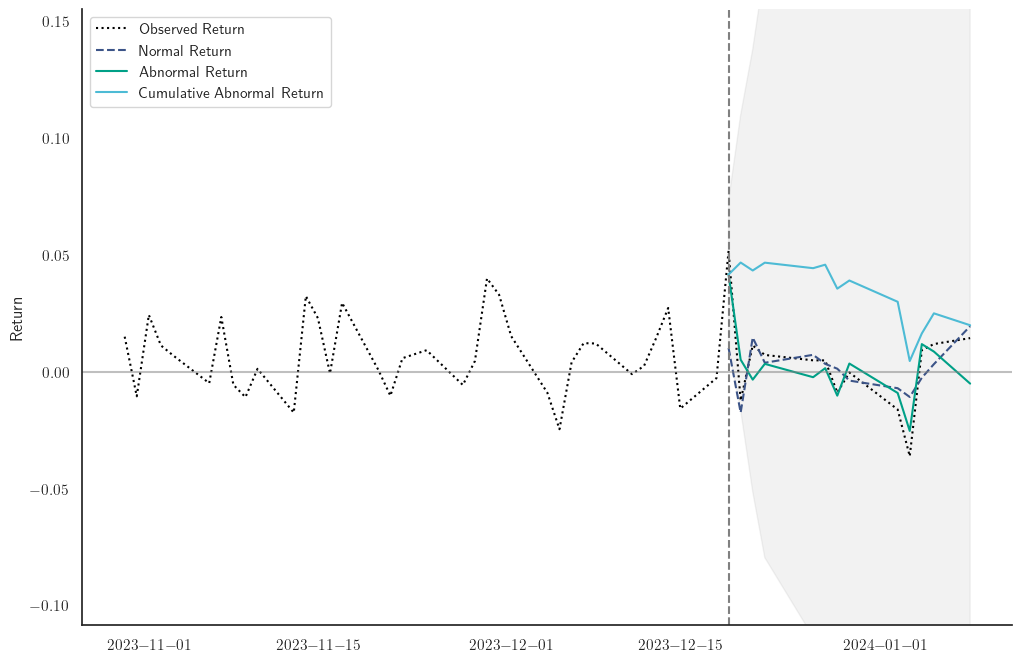

In [175]:
result_plot = plot_CAR_over_time_with_ci_seaborn(
    event_study_results=event_study_results,
    stock_market_data=stock_data,
    event_date=pd.to_datetime('2023-12-19'),
    confidence_level=0.95
)

# Export Results

In [33]:
result_plot.savefig('event_study_result_plot.png')
event_study_results.to_excel('event_study_results.xlsx')